# Clasificación del texto sin preprocesamiento.

En este cuardeno se cargarán los datos que no fueron procesados (datos_sin_procesar.csv). Luego, se realizará el proceso de tokenización, se agregará padding y se pasarán por una red neuronal profunda con una capa de Embedding para realizar el proceso de clasificación. Para mejorar la robustez de la clasificación, también se utilizarán redes LSTM.

## Procesamiento de los datos

In [142]:
import numpy as np
import pandas as pd
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

Se lee los datos

In [143]:
df = pd.read_csv("datos/datos_sin_procesar.csv", sep=";")
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


A continuación se crean las variables "textos" y "etiquetas", las cuales contendrán el texto a clasificar y las etiquetas, respectivamente.

In [144]:
textos = df["Message"].to_list()
textos

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
 'Even my brother is not like to speak with me. They treat me like aids patent.',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had you

In [145]:
etiquetas = df["Category"].values
etiquetas

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

Se divide el conjunto de datos en train y text. 

In [146]:
X_train, X_test, y_train, y_test = train_test_split(textos,  etiquetas, test_size=0.2, random_state=42)

A continuación, se lleva a cabo el proceso de tokenización del texto. Se crea un objeto Tokenizer y se entrena con los textos de X_train. Luego, se utilizan este objeto entrenado para crear las secuencias de los textos en X_train y X_test.

In [147]:
max_words = 10000 #Cantidad máxima de palabras únicas dentro de los textos de X_train
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

#Se crean las secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Para realizar el padding de las secuencias, se calculan los tamaños máximos de las secuencias de entrenamiento y prueba. Posteriormente, se compara cuál secuencia es más grande y se utiliza este valor para realizar el padding en ambas secuencias.

In [148]:
#Se cálcula cual de las dos secuencias es más grande y se guarda ese número para crear el padding
maxlen = max(len(max(X_train_seq, key=len)), len(max(X_test_seq, key=len)))

#Se procede a crear el padding en las dos secuencias con un tamaño definido por maxlen
X_train_padding = pad_sequences(sequences=X_train_seq, maxlen=maxlen, padding="pre")
X_test_padding = pad_sequences(sequences=X_test_seq, maxlen=maxlen, padding="pre")

#Se muestran las formadas de las secuencias obtenidas
X_train_padding.shape, X_test_padding.shape

((4457, 189), (1115, 189))

## Creación del modelo

Para calcular el tamaño de los vectores de incrustación (generados por la capa de embedding), se utiliza el siguiente código:

In [149]:
# Factor de escala
factor_escala = 100

# Calcular output_dim
output_dim = min(300, max(100, max_words // factor_escala))
print("Tamaño de los vectores de incrustación: {}".format(output_dim))

Tamaño de los vectores de incrustación: 100


Se crea la estructura del modelo

In [150]:
modelo = Sequential()
modelo.add(Embedding(input_dim=max_words, output_dim=output_dim, input_length=maxlen))
modelo.add(LSTM(128, return_sequences=True))
modelo.add(LSTM(64))
modelo.add(Dense(64, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(1, activation='sigmoid'))


modelo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])


Se entrena el modelo

In [151]:
modelo.fit(
    X_train_padding,
    y_train,
    epochs = 10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
112/112 [==============================] - 6s 33ms/step - loss: 0.1886 - acc: 0.9433 - val_loss: 0.0703 - val_acc: 0.9776
Epoch 2/10
112/112 [==============================] - 3s 30ms/step - loss: 0.0252 - acc: 0.9927 - val_loss: 0.0677 - val_acc: 0.9832
Epoch 3/10
112/112 [==============================] - 3s 25ms/step - loss: 0.0072 - acc: 0.9989 - val_loss: 0.0937 - val_acc: 0.9809
Epoch 4/10
112/112 [==============================] - 3s 25ms/step - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0987 - val_acc: 0.9809
Epoch 5/10
112/112 [==============================] - 3s 26ms/step - loss: 0.0048 - acc: 0.9989 - val_loss: 0.0731 - val_acc: 0.9843
Epoch 6/10
112/112 [==============================] - 3s 26ms/step - loss: 0.0018 - acc: 0.9997 - val_loss: 0.0929 - val_acc: 0.9865
Epoch 7/10
112/112 [==============================] - 3s 25ms/step - loss: 3.6485e-04 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9865
Epoch 8/10
112/112 [==============================] - 3s 26ms/ste

Se realizan predicciones de las etiquetas de los textos de prueba.

In [152]:
#Predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test_padding)
y_pred = (y_pred > 0.5).astype("int32")

35/35 [==============================] - 1s 9ms/step


## Evalución del modelo

Se emplean diversas métricas de clasificación para evaluar el modelo.


Matriz de Confusión:


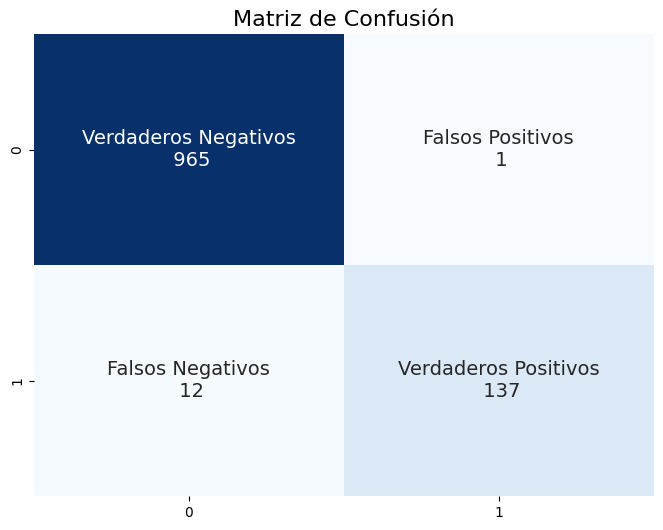

Accuracy:	98.83%
Precision:	99.28%
Recall:		91.95%
F1 Score:	95.47%


In [153]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

#Accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

#Precision
precision = precision_score(y_true=y_test, y_pred=y_pred)

#Recall
recall = recall_score(y_true=y_test, y_pred=y_pred)

#F1 score
f1 = f1_score(y_true=y_test, y_pred=y_pred)

print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Precision:\t{:.2%}".format(precision))
print("Recall:\t\t{:.2%}".format(recall))
print("F1 Score:\t{:.2%}".format(f1))
